In [117]:
%load_ext autoreload
%autoreload 2

# add src to sys-path
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append('../src')
from matplotlib.pyplot import figure
import subprocess
import requests 
from xml.etree.ElementTree import fromstring, ElementTree
from geopy.distance import geodesic
import polyline

LATITUDE_KEY = 'position_lat'
LONGITUDE_KEY = 'position_long'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Preprocessing

In [118]:
def convert_and_read_fit_file(filename):
    subprocess.run(["java", "-jar", "FitSDKRelease_21.16.00/java/FitCSVTool.jar", filename + ".fit"])
    data = pd.read_csv(filename + ".csv")
    datav = data.query("Message == 'record'").values
    return datav       

In [119]:
def filter_data(df):
    COLUMNS = ['distance', 'speed', 'heart_rate', 'altitude', 'SensorHeading', 'SensorAccelerationX_HD', 'SensorAccelerationY_HD', 'SensorAccelerationZ_HD', LATITUDE_KEY, LONGITUDE_KEY]
    SPEED_THRESHOLD = .5
    result = {}

    for row in df:
        current_object = {}
        current_objects = []
        current_timestamp = 0
        for i in range(len(row)):
            column = row[i]

            if column == 'timestamp':
                current_timestamp = row[i+1]
            elif column in COLUMNS:
                if column.endswith("_HD"):
                    current_object[column] = row[i+1]
                # lat/long is written in semicircles
                elif column in [LATITUDE_KEY, LONGITUDE_KEY]:
                    current_object[column] = float(row[i+1]) * 180.0 / 2**31
                else:
                    current_object[column] = float(row[i+1])

        # SPEED THRESHOLD
        if current_object['speed'] >= SPEED_THRESHOLD:
            result[current_timestamp] = current_object

    return result



In [120]:
def split_hd_values(data):
    result = {}
    for timestamp, row in data.items():

        if 'SensorAccelerationX_HD' in row:
            if (type(row['SensorAccelerationX_HD']) is str):
                hd_values_x = row['SensorAccelerationX_HD'].split('|')
                hd_values_y = row['SensorAccelerationY_HD'].split('|')
                hd_values_z = row['SensorAccelerationZ_HD'].split('|')

                for i in range(len(hd_values_x)):
                    new_row = row.copy()
                    new_row['SensorAccelerationX_HD'] = float(hd_values_x[i])
                    new_row['SensorAccelerationY_HD'] = float(hd_values_y[i])
                    new_row['SensorAccelerationZ_HD'] = float(hd_values_z[i])
                    result[int(timestamp) * 1000 + i*4] = new_row
        else:
            result[timestamp] = row

    return result

In [121]:
def get_values_for(data, key):
    return [row[key] for row in list(data.values()) if key in row]

In [163]:
data_1 = convert_and_read_fit_file("warngau_s1")
data_2 = convert_and_read_fit_file("warngau_s2")
data_dif = convert_and_read_fit_file("fortwilliam") #kitzbuehel, dragonbacktrail, fortwilliam, witchestrail2x
print(data_dif[5])       

['Data' 12 'record' 'timestamp' '935682165' 's' 'position_lat' '678067126'
 'semicircles' 'position_long' -59396870.0 'semicircles' 'distance' 25.61
 'm' 'altitude' 597.5999999999998 'm' 'speed' 6.559 'm/s' 'unknown' 100.0
 nan 'heart_rate' 131.0 'bpm' 'temperature' 29.0 'C' 'enhanced_altitude'
 597.5999999999998 'm' 'enhanced_speed' 6.559 'm/s' nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3209: DtypeWarning: Columns (16,23,43,44,47,50,53,56,59,62,65,68,71,83,86,91,92,95,104,107,115,125,128,142,219,222,225,228,231,234,237,240,243,246,249,252,255,258,261,264,267,270,273,276,279) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


In [164]:
filtered_data_1 = filter_data(data_1)
filtered_data_2 = filter_data(data_2)
filtered_data_dif = filter_data(data_dif)

filtered_split_data_1 = split_hd_values(filtered_data_1)
filtered_split_data_2 = split_hd_values(filtered_data_2)
filtered_split_data_dif = split_hd_values(filtered_data_dif)

##  Exploration

In [ ]:
timestamps = list(filtered_split_data_1.keys())
distance = get_values_for(filtered_split_data_1, 'distance')[1::25]
heart_rate = get_values_for(filtered_split_data_1, 'heart_rate')[1::25]
altitude = get_values_for(filtered_split_data_1, 'altitude')[1::25]
speed = get_values_for(filtered_split_data_1, 'speed')[1::25]
sensor_heading = get_values_for(filtered_split_data_1, 'SensorHeading')[1::25]
accX_HD = get_values_for(filtered_split_data_1, 'SensorAccelerationX_HD')
accY_HD = get_values_for(filtered_split_data_1, 'SensorAccelerationY_HD')
accZ_HD = get_values_for(filtered_split_data_1, 'SensorAccelerationZ_HD')


In [ ]:
timestamps_2 = list(filtered_split_data_2.keys())
distance_2 = get_values_for(filtered_split_data_2, 'distance')[1::25]
heart_rate_2 = get_values_for(filtered_split_data_2, 'heart_rate')[1::25]
altitude_2 = get_values_for(filtered_split_data_2, 'altitude')[1::25]
speed_2 = get_values_for(filtered_split_data_2, 'speed')[1::25]
sensor_heading_2 = get_values_for(filtered_split_data_2, 'SensorHeading')[1::25]
accX_HD_2 = get_values_for(filtered_split_data_2, 'SensorAccelerationX_HD')
accY_HD_2 = get_values_for(filtered_split_data_2, 'SensorAccelerationY_HD')
accZ_HD_2 = get_values_for(filtered_split_data_2, 'SensorAccelerationZ_HD')

In [ ]:
figure(num=None, figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
plt.plot(speed)
plt.plot(speed_2)
plt.legend(['Trail 1', 'Trail 2'])
plt.ylabel('Speed in m/s')

In [ ]:
print("Mean Speed S1")
print(np.mean(speed))
print("Mean Speed S2")
print(np.mean(speed_2))

print("\nMedian Speed S1")
print(np.median(speed))
print("Median Speed S2")
print(np.median(speed_2))

print("\nMax Speed S1")
print(np.max(speed))
print("Max Speed S2")
print(np.max(speed_2))

In [ ]:
figure(num=None, figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
plt.plot(altitude)
plt.plot(altitude_2)
plt.legend(['Trail 1', 'Trail 2'])
plt.ylabel('Altitude in m a.s.l.')

In [ ]:
figure(num=None, figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
plt.plot(sensor_heading)
plt.plot(sensor_heading_2)
plt.legend(['Trail 1', 'Trail 2'])
plt.ylabel('Heading')

In [ ]:
figure(num=None, figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
plt.plot(heart_rate)
plt.plot(heart_rate_2)
plt.legend(['Trail 1', 'Trail 2'])
plt.ylabel('Heart Rate')

In [ ]:
figure(num=None, figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
plt.plot(accX_HD)
plt.plot(accY_HD)
plt.plot(accZ_HD)
plt.legend(['X', 'Y', 'Z'])
plt.ylabel('Acceleration Trail 1 in millig')

In [ ]:
figure(num=None, figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
plt.plot(accX_HD_2)
plt.plot(accY_HD_2)
plt.plot(accZ_HD_2)
plt.legend(['X', 'Y', 'Z'])
plt.ylabel('Acceleration Trail 2 in millig')

In [ ]:
print("Mean Acc S1")
print(np.mean(accX_HD), np.mean(accY_HD), np.mean(accZ_HD))
print("Mean Acc S2")
print(np.mean(accX_HD_2), np.mean(accY_HD_2), np.mean(accZ_HD_2))

print("\nMedian Acc S1")
print(np.median(accX_HD), np.mean(accY_HD), np.mean(accZ_HD))
print("Median Acc S2")
print(np.median(accX_HD_2), np.median(accY_HD_2), np.median(accZ_HD_2))

print("\nMax Acc S1")
print(np.max(accX_HD), np.max(accY_HD), np.max(accZ_HD))
print("Max Acc S2")
print(np.max(accX_HD_2), np.max(accY_HD_2), np.max(accZ_HD_2))

In [ ]:
def calculate_descent_per_step(altitude):
    descent = []
    for i in range(len(altitude) - 1):
        current_altitude = altitude[i]
        next_altitude = altitude[i + 1]
        descent.append(current_altitude - next_altitude)
    return descent

descent_1 = calculate_descent_per_step(altitude)
descent_2 = calculate_descent_per_step(altitude_2)
figure(num=None, figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
plt.plot(descent_1)
plt.plot(descent_2)
plt.ylabel('descent')
    

In [ ]:
print("Mean Descent S1")
print(np.mean(descent_1))
print("Mean Descent S2")
print(np.mean(descent_2))

print("\nMedian Descent S1")
print(np.median(descent_1))
print("Median Descent S2")
print(np.median(descent_2))

print("\nMax Descent S1")
print(np.max(descent_1))
print("Max Descent S2")
print(np.max(descent_2))

## Auto Tagging

In [124]:
def get_bounding_box_for_recording(data, padding=0.):
    latitudes = get_values_for(data, LATITUDE_KEY)[1::25]
    longitudes = get_values_for(data, LONGITUDE_KEY)[1::25]

    min_latitude = np.min(latitudes)
    max_latitude = np.max(latitudes)
    min_longitude = np.min(longitudes)
    max_longitude = np.max(longitudes)
    
    top_left = (max_latitude + padding, min_longitude - padding)
    bottom_right = (min_latitude - padding, max_longitude + padding)
    
    return (top_left, bottom_right)

In [125]:
#https://overpass-api.de/api/map?bbox=11.7020,47.6756,11.9303,47.7750
def fetch_area_from_openstreetmap(top_left, bottom_right):
    bbox= 'bbox=' + str(top_left[1]) + ',' + str(bottom_right[0]) + ',' + str(bottom_right[1]) + ',' + str(top_left[0])
    url = 'https://overpass-api.de/api/map?' + bbox
    print("fetching from: ", url)
    response = requests.get(url)
    return response


In [126]:
#https://www.trailforks.com/api/1/maptrails?output=encoded&filter=bbox%3A%3A47.41852456703782%2C12.356023974716663%2C47.41852456703782%2C12.356023974716663&api_key=docs
def fetch_area_from_trailforks(top_left, bottom_right):
    bbox= 'bbox::' + str(top_left[0]) + ',' + str(top_left[1]) + ',' + str(bottom_right[0]) + ',' + str(bottom_right[1])
    url= 'https://www.trailforks.com/api/1/trails?scope=track&filter=' + bbox + '&api_key=docs'
    print("fetching from: ", url)
    response = requests.get(url)
    return response


In [127]:
def create_position_meta_list_for_trailforks(top_left, bottom_right, response = None):
    if response is None:
        response = fetch_area_from_trailforks(top_left, bottom_right)
    datas = response.json()['data']

    for data in datas:
        encoded_path = data['track']['encodedPath']
        decoded_path = polyline.decode(encoded_path)
        del data['track']
        data['positions'] = decoded_path
    
    return datas

In [128]:
def create_position_meta_map_for_openstreetmap(top_left, bottom_right, response = None):
    if response is None:
        response = fetch_area_from_openstreetmap(top_left, bottom_right)
    tree = ElementTree(fromstring(response.content))
    root = tree.getroot()
    position_nodes = {}
    mapped_nodes = {}

    for child in root:
        if (child.tag == 'node'):
            position_nodes[child.attrib['id']] = {'lat': child.attrib['lat'], 'lon': child.attrib['lon']}

    for child in root:
        if (child.tag == 'way'):
            metas = {}

            for sub_child in child:
                if (sub_child.tag == 'tag'):
                    metas[sub_child.attrib['k']] = sub_child.attrib['v']

            for sub_child in child:
                if (sub_child.tag == 'nd'):
                    node = position_nodes[sub_child.attrib['ref']]
                    mapped_nodes[sub_child.attrib['ref']] = {**node, **metas}
                    
    return mapped_nodes


In [129]:
def find_meta_data_for_recording(data):
    latitudes = get_values_for(data, LATITUDE_KEY)[1::25]
    longitudes = get_values_for(data, LONGITUDE_KEY)[1::25]
    closest_items = []
    
    for i in range(len(latitudes)):
        lat = latitudes[i]
        lon = longitudes[i]
        closest_item = {}
        closest_item_trailforks = {}
        smallest_distance = DISTANCE_META_THRESHOLD
        smallest_distance_trailforks = DISTANCE_META_THRESHOLD
        origin = (lat, lon)

        #TODO: Rename variables
        # Loop through OSM data
        for _, position_meta in position_meta_map.items():
            
                if 'mtb:scale' not in position_meta.keys() and 'mtb:type' not in position_meta.keys():
                    continue
                
                # Check if the item is in distance
                dest = (position_meta['lat'], position_meta['lon'])
                distance = geodesic(origin, dest).meters
                
                # Set as the closest OSM item
                if distance < smallest_distance:
                    closest_item = position_meta
                    smallest_distance = distance
                    
        # Loop through Trailforks data
        for position_meta_trailforks in position_meta_list:
            # Loop through positions in trailforks data
            for latitude, longitude in position_meta_trailforks['positions']:
                
                # Check if the item is in distance
                dest = (latitude, longitude)
                distance = geodesic(origin, dest).meters

                # Set as the closest trailforks item
                if distance < smallest_distance_trailforks:
                    closest_item_trailforks = position_meta_trailforks
                    smallest_distance_trailforks = distance
                    
        if closest_item or closest_item_trailforks:
            closest_items.append({**closest_item, **closest_item_trailforks})
        elif len(closest_items) > 0:
            closest_items.append(closest_items[-1])
        else:
            closest_items.append({})
            
    for closest_item in closest_items:
        if 'encodedPath' in closest_item:
            del closest_item['encodedPath']
        if 'positions' in closest_item:
            del closest_item['positions']
        if 'encodedLevels' in closest_item:
            del closest_item['encodedLevels']
        
    return closest_items

In [165]:
top_left, bottom_right = get_bounding_box_for_recording(filtered_split_data_dif, padding=0.03)
response_osm = fetch_area_from_openstreetmap(top_left, bottom_right)
response_trailforks = fetch_area_from_trailforks(top_left, bottom_right)

fetching from:  https://overpass-api.de/api/map?bbox=-5.030291392207146,56.80459801599383,-4.948178758174181,56.88046344995499
fetching from:  https://www.trailforks.com/api/1/trails?scope=track&filter=bbox::56.88046344995499,-5.030291392207146,56.80459801599383,-4.948178758174181&api_key=docs


In [166]:
DISTANCE_META_THRESHOLD = 10# in meters
position_meta_map = create_position_meta_map_for_openstreetmap(top_left, bottom_right, response_osm)
position_meta_list = create_position_meta_list_for_trailforks(top_left, bottom_right, response_trailforks)
closest_items = find_meta_data_for_recording(filtered_split_data_dif)

In [161]:
response_trailforks.content

b'{"error":0,"message":"","data":[{"trailid":"6640","vid":"5","title":"Fort William World Cup DH Track","rid":"4306","difficulty":"8","activitytype":1,"trailtype":"1","biketype":"1","physical_rating":"4","ttfs":"17,16,18,21","wet_weather":"1","season":"May-Sep","unsanctioned":"0","hidden":"0","rating":"100","votes":"17","ridden":"287","faved":"1","status":"1","products":"","total_comments":"3","total_photos":"3661","total_videos":"109","total_reports":"6","total_poi":"0","total_supporters":"0","total_osmways":"6","created":"1405787387","changed":"1527805078","last_comment_ts":"0","last_report_ts":"1569782105","last_totals_ts":"1574930911","alias":"fort-william-world-cup-dh-track","approved":"0","userid":"904521","published":"1","dirty":"0","views":"20660","trackid":"188608","condition":"4","confirmid":"2699","download_disable":"0","usage":"1","direction":"1","opendate":"0","strava_segment":"0","strava_segment_reverse":"0","legacy_id":"0","closed":"0","climb_difficulty":"0","land_manage

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


Text(0, 0.5, 'Trail: Top Chief, Fort William (normalized)')

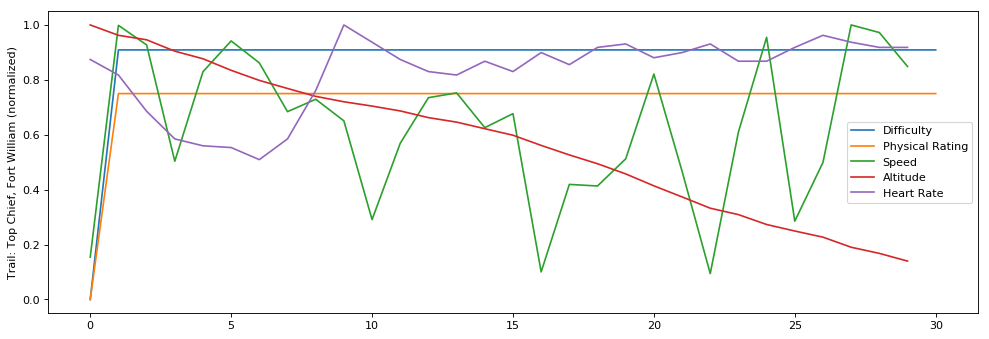

In [167]:
figure(num=None, figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')


trailforks_difficulties = [0]
osm_difficulties = [0]
physical_ratings = [0]

for closest_item in closest_items:
    difficulty = closest_item['difficulty'] if 'difficulty' in closest_item else trailforks_difficulties[-1]
    mtb_scale = closest_item['mtb:scale'] if 'mtb:scale' in closest_item else osm_difficulties[-1]
    physical_rating = closest_item['physical_rating'] if 'physical_rating' in closest_item else physical_ratings[-1]
    trailforks_difficulties.append(difficulty)
    osm_difficulties.append(mtb_scale)
    physical_ratings.append(physical_rating)
    
trailforks_difficulty_results = np.array(trailforks_difficulties).astype(int) 
osm_difficulty_results = np.array(osm_difficulties).astype(int) 
physical_ratings_results = np.array(physical_ratings).astype(int) 

altitude_dif = np.array(get_values_for(filtered_split_data_dif, 'altitude')[1::25])
speed_dif = np.array(get_values_for(filtered_split_data_dif, 'speed')[1::25])
heart_rate_dif = np.array(get_values_for(filtered_split_data_dif, 'heart_rate')[1::25])

norm_dif_trailforks = np.divide(trailforks_difficulty_results, 11)
norm_dif_osm = osm_difficulty_results / osm_difficulty_results.max(axis=0)
norm_speed = speed_dif / speed_dif.max(axis=0)
norm_altitude = altitude_dif / altitude_dif.max(axis=0)
norm_physical_ratings = np.divide(physical_ratings_results, 4)

if len(heart_rate_dif):
    norm_heart_rate = heart_rate_dif / heart_rate_dif.max(axis=0)

plt.plot(norm_dif_trailforks)
#plt.plot(norm_dif_osm)
plt.plot(norm_physical_ratings)
plt.plot(norm_speed)
plt.plot(norm_altitude)
if len(heart_rate_dif):
    plt.plot(norm_heart_rate)
#plt.legend(['Difficulty Trailforks', 'Difficulty OSM', 'Physical Ratings', 'Speed', 'Altitude', 'Heart Rate'])
plt.legend(['Difficulty', 'Physical Rating', 'Speed', 'Altitude', 'Heart Rate'])
plt.ylabel('Trail: Top Chief, Fort William (normalized)')
